### DATALoading(final_split_training)

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
import math
from timm.models.swin_transformer import SwinTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import StepLR

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
path="../../input/final_split_15Apr2025/train"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)


Reduced Train: 8025


In [ ]:
path="../../input/final_split_15Apr2025/test"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Test: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Test: 572


In [4]:
from collections import Counter

# Get the list of all targets (i.e., class indices)
targets = [label for _, label in evalSet]

# Count each class
class_counts = Counter(targets)

# Map class indices to names
idx_to_class = {v: k for k, v in evalSet.class_to_idx.items()}

# Print class name and count
for class_idx, count in sorted(class_counts.items()):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {count}")


angry: 140
happy: 148
relaxed: 146
sad: 138


In [5]:
# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)

4


### DataLoading (dilb)

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
import math
from timm.models.swin_transformer import SwinTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.optim.lr_scheduler import StepLR

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path="../../input/dlib_dog_emotion_dataset/train"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)

Reduced Train: 24370


In [3]:
path="../../input/dlib_dog_emotion_dataset/test"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Test: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Test: 709


In [4]:
from collections import Counter

# Get the list of all targets (i.e., class indices)
targets = [label for _, label in evalSet]

# Count each class
class_counts = Counter(targets)

# Map class indices to names
idx_to_class = {v: k for k, v in evalSet.class_to_idx.items()}

# Print class name and count
for class_idx, count in sorted(class_counts.items()):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {count}")

# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)


angry: 157
happy: 236
relaxed: 205
sad: 111
4


## SEC2nd

Idk I tried to switch the dataset s and reduce the learning rate, maybe can try other changes

the answer being that I had normalization on train and test but not eval

Removing Normalization cause not being added to all and adding resizing to 456 which was based on the kind of stuff it was for

accuracy up to 0.8774

adding back normalization to all and trying again

Honestly the difference seems trivia|

### Code Strucutre

In [7]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

num_classes = len(reducedDataset.dataset.classes)
print("Number of classes:", num_classes)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
        param.requires_grad = True


# Add SE block + classifier
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),          # Reshape [B, C] → [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                               # Back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

Number of classes: 4


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [ ]:
epochs = 50
bestAcc = 0.0
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epoch_loss)
    trainAccs.append(acc)

    model.eval()
    evalLoss = 0
    evalCorrect = 0
    evalTotal = 0
    
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            evalLoss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            evalCorrect += (predicted == labels).sum().item()
            evalTotal += labels.size(0)
        
    valLoss = evalLoss / evalTotal
    valAcc = evalCorrect / evalTotal
    valLosses.append(valLoss)
    valAccs.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")

    if valAcc > bestAcc:
        bestAcc = valAcc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/unclean/SEC2nd.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


NameError: name 'model' is not defined

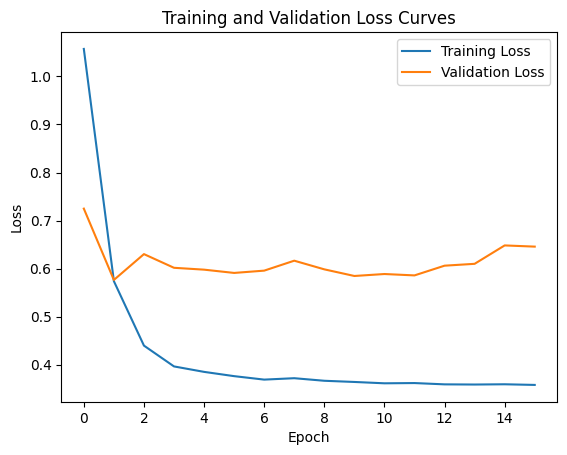

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


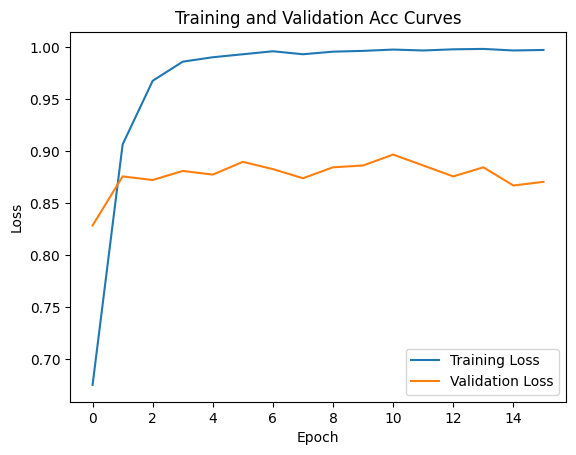

In [9]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [ ]:
path="../../input/final_split_15Apr2025/eval"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 579


In [11]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [12]:
from torchvision.models import efficientnet_b5
import torch.nn as nn
import torch

# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Load EfficientNet structure
model = efficientnet_b5(weights=None)

# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),           # restore shape to [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                                # back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/SEC2nd.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [13]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8929
Classification Report:
              precision    recall  f1-score   support

       angry       0.94      0.83      0.88       142
       happy       0.94      0.91      0.93       150
     relaxed       0.87      0.87      0.87       148
         sad       0.83      0.96      0.89       139

    accuracy                           0.89       579
   macro avg       0.90      0.89      0.89       579
weighted avg       0.90      0.89      0.89       579

Confusion Matrix:
[[118   7   9   8]
 [  7 137   5   1]
 [  0   1 129  18]
 [  1   0   5 133]]


In [14]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

4260

## SEFC

### Code Strucutre

In [11]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

optimizer = optim.Adam(model.base.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

### Training

In [ ]:
epochs = 50
bestAcc = 0.0
bestLoss = math.inf
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epochLoss)
    trainAccs.append(acc)

    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    valAcc = eval_correct / eval_total
    valLosses.append(valLoss)
    valAccs.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")
    if valLoss < bestLoss:
        bestLoss = valLoss
        triggerTimes = 0
        torch.save(model.state_dict(), "../../models/unclean/SEFC.pth")
    else:
        triggerTimes += 1
        print(f"No improvement. Trigger {triggerTimes}/{patience}")

        if triggerTimes >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Loss: 1.1529 Accuracy: 0.5515
Eval  Loss: 1.0476 | Accuracy: 0.5769
Epoch [2/50] Loss: 0.8863 Accuracy: 0.6784
Eval  Loss: 0.8346 | Accuracy: 0.6801
Epoch [3/50] Loss: 0.7159 Accuracy: 0.7521
Eval  Loss: 0.7370 | Accuracy: 0.7133
Epoch [4/50] Loss: 0.5670 Accuracy: 0.8180
Eval  Loss: 0.6708 | Accuracy: 0.7378
Epoch [5/50] Loss: 0.4297 Accuracy: 0.8818
Eval  Loss: 0.6248 | Accuracy: 0.7692
Epoch [6/50] Loss: 0.3134 Accuracy: 0.9290
Eval  Loss: 0.6058 | Accuracy: 0.7622
Epoch [7/50] Loss: 0.2217 Accuracy: 0.9577
Eval  Loss: 0.5782 | Accuracy: 0.7815
Epoch [8/50] Loss: 0.1547 Accuracy: 0.9789
Eval  Loss: 0.5759 | Accuracy: 0.7937
Epoch [9/50] Loss: 0.1058 Accuracy: 0.9921
Eval  Loss: 0.5768 | Accuracy: 0.7937
No improvement. Trigger 1/5
Epoch [10/50] Loss: 0.0729 Accuracy: 0.9969
Eval  Loss: 0.5907 | Accuracy: 0.7885
No improvement. Trigger 2/5
Epoch [11/50] Loss: 0.0508 Accuracy: 0.9995
Eval  Loss: 0.5960 | Accuracy: 0.7885
No improvement. Trigger 3/5
Epoch [12/50] Loss: 0.0

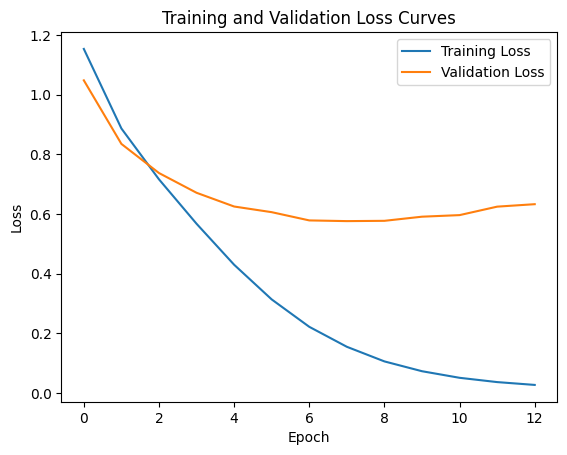

In [13]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


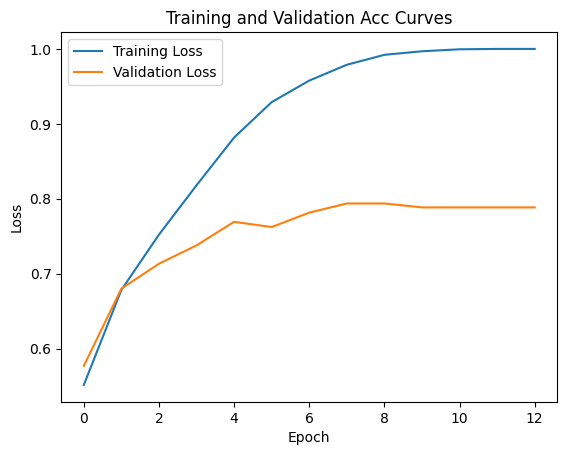

In [14]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [ ]:
path="../../input/final_split_15Apr2025/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 572


In [16]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [17]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/SEFC.pth"))
model.eval()


CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [18]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.6101
Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.38      0.52       140
       happy       0.59      0.78      0.67       148
     relaxed       0.53      0.65      0.58       146
         sad       0.65      0.62      0.63       138

    accuracy                           0.61       572
   macro avg       0.65      0.61      0.60       572
weighted avg       0.65      0.61      0.60       572

Confusion Matrix:
[[ 53  40  24  23]
 [  5 115  25   3]
 [  3  27  95  21]
 [  3  14  35  86]]


In [19]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

4134

## Robust Classifier

Somehwat based on the paper, but honestly this might be something we have to actually train on a gpu cluster

### Code Structure

In [6]:
# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
# Load EfficientNet structure

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

# Freeze everything
for param in model.parameters():
    param.requires_grad = False


# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(2048, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    DenseResidualBlock(in_features=256),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss()
# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [7]:
epochs = 50
bestAcc = 0.0
bestLoss = math.inf
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []


for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epochLoss)
    trainAccs.append(acc)


    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    val_acc = eval_correct / eval_total
    valLosses.append(valLoss)
    valAccs.append(val_acc)

    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {val_acc:.4f}")
    if valLoss < bestLoss:
        bestLoss = valLoss
        triggerTimes = 0
        torch.save(model.state_dict(), "../../models/unclean/SEN.pth")
    else:
        triggerTimes += 1
        print(f"No improvement. Trigger {triggerTimes}/{patience}")

        if triggerTimes >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Loss: 1.4347 Accuracy: 0.3127
Eval  Loss: 1.2947 | Accuracy: 0.3549
Epoch [2/50] Loss: 0.9839 Accuracy: 0.5954
Eval  Loss: 0.7866 | Accuracy: 0.6783
Epoch [3/50] Loss: 0.5977 Accuracy: 0.7734
Eval  Loss: 0.6992 | Accuracy: 0.7255
Epoch [4/50] Loss: 0.3585 Accuracy: 0.8739
Eval  Loss: 0.6995 | Accuracy: 0.7308
No improvement. Trigger 1/5
Epoch [5/50] Loss: 0.1962 Accuracy: 0.9376
Eval  Loss: 0.8003 | Accuracy: 0.7395
No improvement. Trigger 2/5
Epoch [6/50] Loss: 0.0948 Accuracy: 0.9766
Eval  Loss: 0.8432 | Accuracy: 0.7587
No improvement. Trigger 3/5
Epoch [7/50] Loss: 0.0371 Accuracy: 0.9948
Eval  Loss: 0.9963 | Accuracy: 0.7413
No improvement. Trigger 4/5
Epoch [8/50] Loss: 0.0164 Accuracy: 0.9986
Eval  Loss: 1.0319 | Accuracy: 0.7587
No improvement. Trigger 5/5
Early stopping triggered.


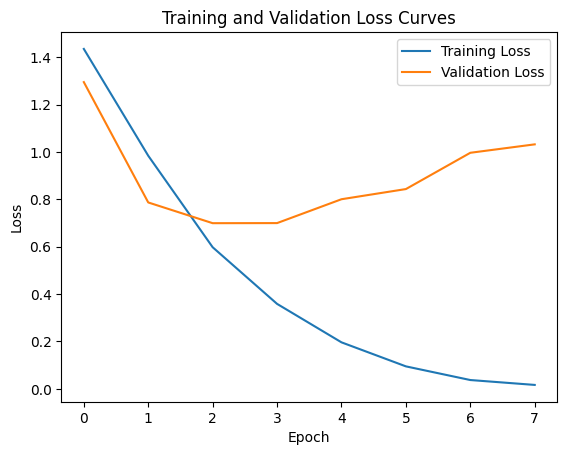

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


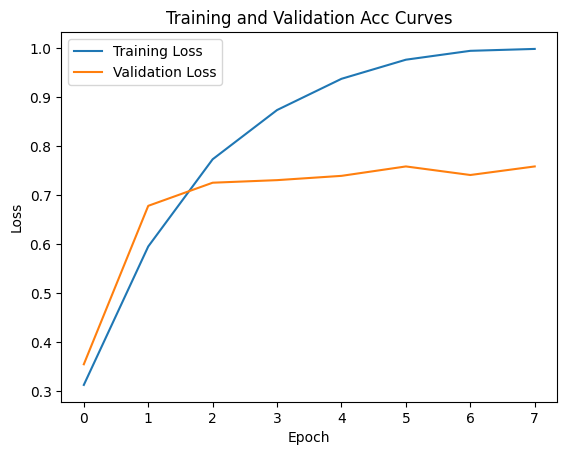

In [9]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [ ]:
path="../../input/final_split_15Apr2025/test"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 572


In [11]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [13]:
# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
# Load EfficientNet structure

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

# Freeze everything
for param in model.parameters():
    param.requires_grad = False


# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(2048, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    DenseResidualBlock(in_features=256),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)

# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/SEN.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [14]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.7255
Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.66      0.74       140
       happy       0.73      0.72      0.73       148
     relaxed       0.61      0.73      0.66       146
         sad       0.78      0.79      0.78       138

    accuracy                           0.73       572
   macro avg       0.74      0.73      0.73       572
weighted avg       0.74      0.73      0.73       572

Confusion Matrix:
[[ 93  19  17  11]
 [  9 107  31   1]
 [  4  17 106  19]
 [  5   3  21 109]]


## SWIN

### Code structure

In [6]:
# --- Patch to Override Hash Check for EfficientNet weights ---
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# --- Squeeze-Excitation Block ---
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- Combined Model: EfficientNet-B5 Backbone + SE Block + Swin Transformer ---
class EfficientNetSwin(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetSwin, self).__init__()
        # Load EfficientNet-B5 backbone with pretrained weights.
        self.backbone = efficientnet_b5(weights="DEFAULT").features
        
        # Freeze all layers except for the last two blocks
        for param in self.backbone.parameters():
            param.requires_grad = False
        for name, param in self.backbone.named_parameters():
            if "6" in name or "7" in name:
                param.requires_grad = True

        # Add a Squeeze-Excitation block after the backbone (input channels: 2048)
        self.se = SqueezeExcitationBlock(2048)
        
        # 1x1 convolution to project from 2048 channels to 96 channels required by Swin.
        self.project = nn.Conv2d(2048, 96, kernel_size=1)
        
        # Adaptive pooling to resize the feature map.
        # We choose 14x14 so that it works well with Swin's img_size=14 and window_size=7.
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))
        
        # Initialize the Swin Transformer for classification.
        # Make sure that the img_size here matches the size output by adapt_pool.
        self.swin = SwinTransformer(
            img_size=14,         # Should match the adaptive pool output size.
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,       # 14 % 7 == 0 (good!)
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )
        
    def forward(self, x):
        # Extract features using EfficientNet-B5.
        x = self.backbone(x)       # Expected shape: [B, 2048, H, W] (typically 7x7 or so)
        x = self.se(x)             # Apply Squeeze-Excitation
        x = self.project(x)        # Project to 96 channels -> shape: [B, 96, H, W]
        x = self.adapt_pool(x)     # Resize to [B, 96, 14, 14]
        x = self.swin(x)           # Pass through Swin Transformer; output: [B, num_classes]
        return x


num_classes = len(reducedDataset.dataset.classes)
print("Number of classes:", num_classes)

model = EfficientNetSwin(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

model.train()


Number of classes: 4


EfficientNetSwin(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNor

### Training

In [7]:
epochs = 50
bestAcc = 0.0
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epoch_loss)
    trainAccs.append(acc)

    model.eval()
    evalLoss = 0
    evalCorrect = 0
    evalTotal = 0
    
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            evalLoss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            evalCorrect += (predicted == labels).sum().item()
            evalTotal += labels.size(0)
        
    valLoss = evalLoss / evalTotal
    valAcc = evalCorrect / evalTotal
    valLosses.append(valLoss)
    valAccs.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")
    if valAcc > bestAcc:
        bestAcc = valAcc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/unclean/SWIN.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Loss: 0.9282 Accuracy: 0.6726
Eval  Loss: 0.7054 | Accuracy: 0.8147
Epoch [2/50] Loss: 0.4996 Accuracy: 0.9319
Eval  Loss: 0.6718 | Accuracy: 0.8584
Epoch [3/50] Loss: 0.4053 Accuracy: 0.9795
Eval  Loss: 0.6510 | Accuracy: 0.8601
Epoch [4/50] Loss: 0.3797 Accuracy: 0.9900
Eval  Loss: 0.6532 | Accuracy: 0.8706
Epoch [5/50] Loss: 0.3803 Accuracy: 0.9876
Eval  Loss: 0.6641 | Accuracy: 0.8601
No improvement. Trigger 1/5
Epoch [6/50] Loss: 0.3744 Accuracy: 0.9894
Eval  Loss: 0.7029 | Accuracy: 0.8549
No improvement. Trigger 2/5
Epoch [7/50] Loss: 0.3756 Accuracy: 0.9881
Eval  Loss: 0.6889 | Accuracy: 0.8689
No improvement. Trigger 3/5
Epoch [8/50] Loss: 0.3748 Accuracy: 0.9898
Eval  Loss: 0.6435 | Accuracy: 0.8759
Epoch [9/50] Loss: 0.3647 Accuracy: 0.9936
Eval  Loss: 0.6844 | Accuracy: 0.8566
No improvement. Trigger 1/5
Epoch [10/50] Loss: 0.3709 Accuracy: 0.9898
Eval  Loss: 0.6395 | Accuracy: 0.8724
No improvement. Trigger 2/5
Epoch [11/50] Loss: 0.3611 Accuracy: 0.9954
Eval 

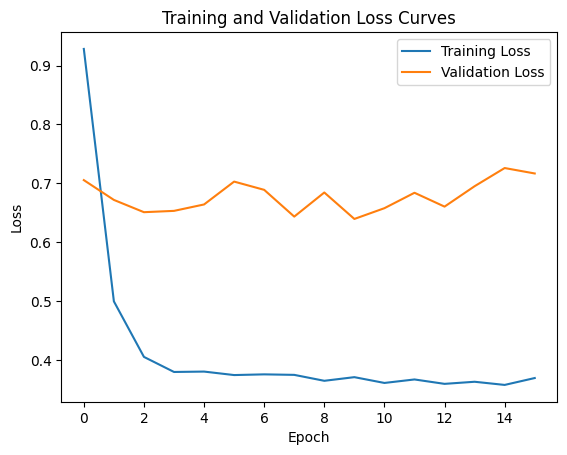

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


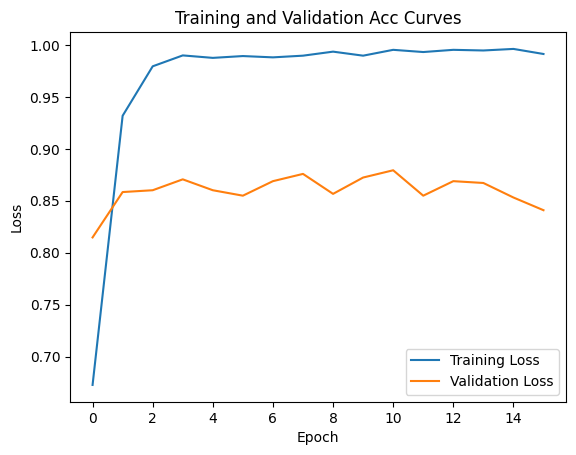

In [9]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [ ]:
path="../../input/final_split_15Apr2025/eval"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)

Test set: 579


In [11]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [14]:
# --- Patch to Override Hash Check for EfficientNet weights ---
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash", None)
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# --- Squeeze-Excitation Block ---
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- Combined Model: EfficientNet-B5 Backbone + SE Block + Swin Transformer ---
class EfficientNetSwin(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetSwin, self).__init__()
        # Load EfficientNet-B5 backbone with pretrained weights.
        self.backbone = efficientnet_b5(weights="DEFAULT").features
        
        # Freeze all layers except for the last two blocks
        for param in self.backbone.parameters():
            param.requires_grad = False
        for name, param in self.backbone.named_parameters():
            if "6" in name or "7" in name:
                param.requires_grad = True

        # Add a Squeeze-Excitation block after the backbone (input channels: 2048)
        self.se = SqueezeExcitationBlock(2048)
        
        # 1x1 convolution to project from 2048 channels to 96 channels required by Swin.
        self.project = nn.Conv2d(2048, 96, kernel_size=1)
        
        # Adaptive pooling to resize the feature map.
        # We choose 14x14 so that it works well with Swin's img_size=14 and window_size=7.
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))
        
        # Initialize the Swin Transformer for classification.
        # Make sure that the img_size here matches the size output by adapt_pool.
        self.swin = SwinTransformer(
            img_size=14,         # Should match the adaptive pool output size.
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,       # 14 % 7 == 0 (good!)
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )
        
    def forward(self, x):
        # Extract features using EfficientNet-B5.
        x = self.backbone(x)       # Expected shape: [B, 2048, H, W] (typically 7x7 or so)
        x = self.se(x)             # Apply Squeeze-Excitation
        x = self.project(x)        # Project to 96 channels -> shape: [B, 96, H, W]
        x = self.adapt_pool(x)     # Resize to [B, 96, 14, 14]
        x = self.swin(x)           # Pass through Swin Transformer; output: [B, num_classes]
        return x


num_classes = len(reducedDataset.dataset.classes)
print("Number of classes:", num_classes)

model = EfficientNetSwin(num_classes=num_classes)
model.load_state_dict(torch.load("../../models/unclean/SWIN.pth"))
model.eval()

Number of classes: 4


EfficientNetSwin(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNor

In [15]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8653
Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.82      0.86       142
       happy       0.88      0.94      0.91       150
     relaxed       0.84      0.81      0.82       148
         sad       0.84      0.88      0.86       139

    accuracy                           0.87       579
   macro avg       0.87      0.86      0.86       579
weighted avg       0.87      0.87      0.86       579

Confusion Matrix:
[[117  13   8   4]
 [  4 141   5   0]
 [  2   6 120  20]
 [  6   0  10 123]]


## SwinFicientNet

### Code Structure

In [ ]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class SwinFicientNet(nn.Module):
    """
    EfficientNetB5 with optional SE block and configurable classifier for Ray Tune.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        super(SwinFicientNet, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        self.se = SqueezeExcitationBlock(2048)
        self.project = nn.Conv2d(2048, 96, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))
        self.swin = SwinTransformer(
            img_size=14,         # Should match the adaptive pool output size.
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,       # 14 % 7 == 0 (good!)
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )
        in_features = self.backbone.classifier[1].in_features

        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
    
    
    def forward(self, x):
        # Extract features using EfficientNet-B5.
        x = self.backbone(x)       # Expected shape: [B, 2048, H, W] (typically 7x7 or so)
        x = self.se(x)             # Apply Squeeze-Excitation
        x = self.project(x)        # Project to 96 channels -> shape: [B, 96, H, W]
        x = self.adapt_pool(x)     # Resize to [B, 96, 14, 14]
        x = self.swin(x)           # Pass through Swin Transformer; output: [B, num_classes]
        return x

# Dilb

## SEC2nd

### Code Structure

In [5]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

num_classes = len(reducedDataset.dataset.classes)
print("Number of classes:", num_classes)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
        param.requires_grad = True


# Add SE block + classifier
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),          # Reshape [B, C] → [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                               # Back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

Number of classes: 4


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [6]:
epochs = 50
bestAcc = 0.0
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epoch_loss)
    trainAccs.append(acc)

    model.eval()
    evalLoss = 0
    evalCorrect = 0
    evalTotal = 0
    
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            evalLoss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            evalCorrect += (predicted == labels).sum().item()
            evalTotal += labels.size(0)
        
    valLoss = evalLoss / evalTotal
    valAcc = evalCorrect / evalTotal
    valLosses.append(valLoss)
    valAccs.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")

    if valAcc > bestAcc:
        bestAcc = valAcc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/clean/SEC2nd.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/50] Loss: 0.8352 Accuracy: 0.7648
Eval  Loss: 0.6774 | Accuracy: 0.8533
Epoch [2/50] Loss: 0.4830 Accuracy: 0.9401
Eval  Loss: 0.6811 | Accuracy: 0.8563
Epoch [3/50] Loss: 0.4066 Accuracy: 0.9803
Eval  Loss: 0.6932 | Accuracy: 0.8533
No improvement. Trigger 1/5
Epoch [4/50] Loss: 0.3817 Accuracy: 0.9908
Eval  Loss: 0.6899 | Accuracy: 0.8593
Epoch [5/50] Loss: 0.3721 Accuracy: 0.9938
Eval  Loss: 0.7100 | Accuracy: 0.8413
No improvement. Trigger 1/5
Epoch [6/50] Loss: 0.3692 Accuracy: 0.9937
Eval  Loss: 0.6937 | Accuracy: 0.8623
Epoch [7/50] Loss: 0.3628 Accuracy: 0.9971
Eval  Loss: 0.6865 | Accuracy: 0.8683
Epoch [8/50] Loss: 0.3615 Accuracy: 0.9964
Eval  Loss: 0.7101 | Accuracy: 0.8563
No improvement. Trigger 1/5
Epoch [9/50] Loss: 0.3599 Accuracy: 0.9971
Eval  Loss: 0.6825 | Accuracy: 0.8683
No improvement. Trigger 2/5
Epoch [10/50] Loss: 0.3593 Accuracy: 0.9969
Eval  Loss: 0.6954 | Accuracy: 0.8653
No improvement. Trigger 3/5
Epoch [11/50] Loss: 0.3559 Accuracy: 0.9983
Eval 

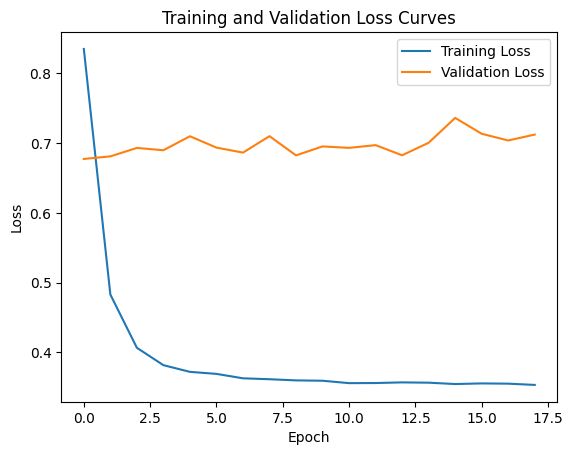

In [7]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


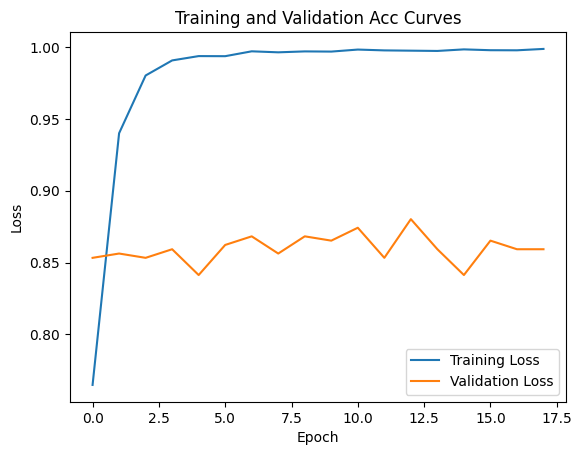

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/dlib_dog_emotion_dataset/eval"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)

# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

Test set: 340
4


In [10]:
from torchvision.models import efficientnet_b5
import torch.nn as nn
import torch

# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Load EfficientNet structure
model = efficientnet_b5(weights=None)

# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),           # restore shape to [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                                # back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)

# Load weights
model.load_state_dict(torch.load("../../models/clean/SEC2nd.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8824
Classification Report:
              precision    recall  f1-score   support

       angry       0.91      0.86      0.89        87
       happy       0.94      0.91      0.92       129
     relaxed       0.81      0.95      0.88       109
         sad       0.80      0.27      0.40        15

    accuracy                           0.88       340
   macro avg       0.87      0.75      0.77       340
weighted avg       0.88      0.88      0.88       340

Confusion Matrix:
[[ 75   6   5   1]
 [  4 117   8   0]
 [  3   2 104   0]
 [  0   0  11   4]]


In [12]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

9

## SEFC

### Code Structure

In [5]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

optimizer = optim.Adam(model.base.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

### Training

In [6]:
epochs = 50
bestAcc = 0.0
bestLoss = math.inf
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epochLoss)
    trainAccs.append(acc)

    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    valAcc = eval_correct / eval_total
    valLosses.append(valLoss)
    valAccs.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")
    if valLoss < bestLoss:
        bestLoss = valLoss
        triggerTimes = 0
        torch.save(model.state_dict(), "../../models/clean/SEFC.pth")
    else:
        triggerTimes += 1
        print(f"No improvement. Trigger {triggerTimes}/{patience}")

        if triggerTimes >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Loss: 1.1037 Accuracy: 0.5517
Eval  Loss: 0.9010 | Accuracy: 0.6601
Epoch [2/50] Loss: 0.8517 Accuracy: 0.6687
Eval  Loss: 0.7330 | Accuracy: 0.7334
Epoch [3/50] Loss: 0.6792 Accuracy: 0.7456
Eval  Loss: 0.6113 | Accuracy: 0.7800
Epoch [4/50] Loss: 0.5221 Accuracy: 0.8173
Eval  Loss: 0.5215 | Accuracy: 0.8124
Epoch [5/50] Loss: 0.3851 Accuracy: 0.8789
Eval  Loss: 0.4568 | Accuracy: 0.8392
Epoch [6/50] Loss: 0.2722 Accuracy: 0.9278
Eval  Loss: 0.4034 | Accuracy: 0.8660
Epoch [7/50] Loss: 0.1876 Accuracy: 0.9598
Eval  Loss: 0.3775 | Accuracy: 0.8773
Epoch [8/50] Loss: 0.1234 Accuracy: 0.9821
Eval  Loss: 0.3637 | Accuracy: 0.8928
Epoch [9/50] Loss: 0.0795 Accuracy: 0.9926
Eval  Loss: 0.3634 | Accuracy: 0.8858
Epoch [10/50] Loss: 0.0494 Accuracy: 0.9977
Eval  Loss: 0.3638 | Accuracy: 0.8984
No improvement. Trigger 1/5
Epoch [11/50] Loss: 0.0306 Accuracy: 0.9996
Eval  Loss: 0.3776 | Accuracy: 0.8886
No improvement. Trigger 2/5
Epoch [12/50] Loss: 0.0186 Accuracy: 0.9999
Eval  L

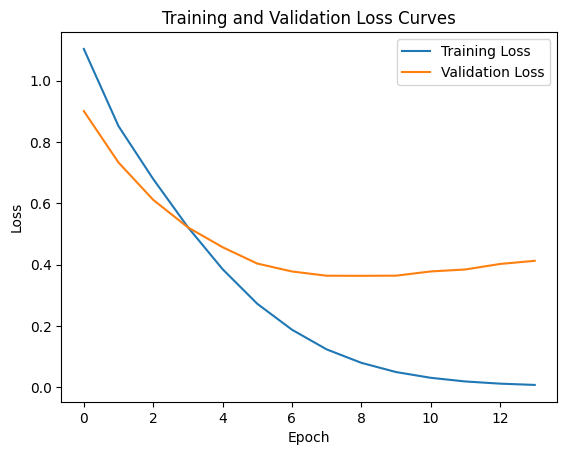

In [7]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


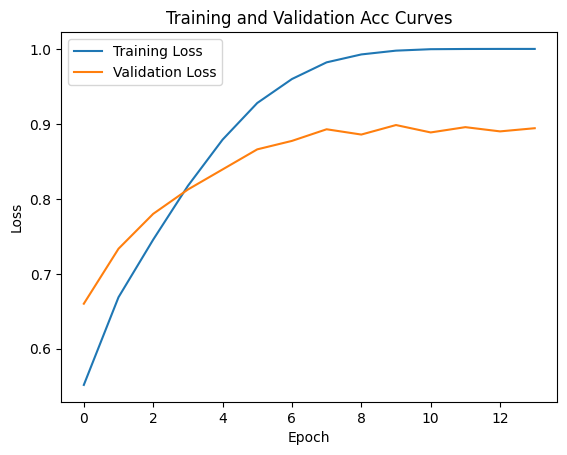

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/dlib_dog_emotion_dataset/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 709


In [10]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [11]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(

        )
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)    

class CustomENB5(nn.Module):
    def __init__(self,num_classes):
        super(CustomENB5, self).__init__()
        WeightsEnum.get_state_dict = get_state_dict

        self.base = efficientnet_b5(weights="DEFAULT")
        for param in self.base.parameters():
            param.requires_grad = False
            
        for name, param in self.base.named_parameters():
            if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
                param.requires_grad = True
            
        
        self.seAfterFeature = SqueezeExcitationBlock(
            channels=2048
        )

        self.base.classifier = nn.Sequential(
            nn.Unflatten(1, (2048, 1, 1)),         
            SqueezeExcitationBlock(2048),
            nn.Flatten(),                            
            nn.Dropout(p=0.4),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.base.features(x)
        x = self.seAfterFeature(x)
        x = self.base.avgpool(x)
        x = torch.flatten(x,1)
        x = self.base.classifier(x)
        return x        
    
model = CustomENB5(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/clean/SEFC.pth"))
model.eval()


CustomENB5(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [12]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.5543
Classification Report:
              precision    recall  f1-score   support

       angry       0.61      0.34      0.44       157
       happy       0.67      0.70      0.68       236
     relaxed       0.54      0.56      0.55       205
         sad       0.36      0.53      0.43       111

    accuracy                           0.55       709
   macro avg       0.55      0.53      0.53       709
weighted avg       0.57      0.55      0.55       709

Confusion Matrix:
[[ 54  49  22  32]
 [ 19 165  36  16]
 [  9  25 115  56]
 [  6   7  39  59]]


In [13]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

18

In [ ]:
##

## Robust Classifier

In [5]:
# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
# Load EfficientNet structure

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

# Freeze everything
for param in model.parameters():
    param.requires_grad = False


# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(2048, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    DenseResidualBlock(in_features=256),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss()
# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [6]:
epochs = 50
bestAcc = 0.0
bestLoss = math.inf
patience = 5
triggerTimes = 0
trainLosses = []
trainAccs = []
valLosses = []
valAccs = []


for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    epochLoss = running_loss / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {acc:.4f}")
    trainLosses.append(epochLoss)
    trainAccs.append(acc)


    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for images, labels in valLoader:  # assumes valLoader is defined
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct += (predicted == labels).sum().item()
            eval_total += labels.size(0)

    valLoss = eval_loss / eval_total
    val_acc = eval_correct / eval_total
    valLosses.append(valLoss)
    valAccs.append(val_acc)

    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {val_acc:.4f}")
    if valLoss < bestLoss:
        bestLoss = valLoss
        triggerTimes = 0
        torch.save(model.state_dict(), "../../models/clean/SEN.pth")
    else:
        triggerTimes += 1
        print(f"No improvement. Trigger {triggerTimes}/{patience}")

        if triggerTimes >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Loss: 1.3849 Accuracy: 0.3310
Eval  Loss: 1.1091 | Accuracy: 0.5529
Epoch [2/50] Loss: 0.8907 Accuracy: 0.6314
Eval  Loss: 0.7049 | Accuracy: 0.7320
Epoch [3/50] Loss: 0.6544 Accuracy: 0.7366
Eval  Loss: 0.5836 | Accuracy: 0.8039
Epoch [4/50] Loss: 0.4792 Accuracy: 0.8150
Eval  Loss: 0.4975 | Accuracy: 0.8420
Epoch [5/50] Loss: 0.3345 Accuracy: 0.8757
Eval  Loss: 0.4655 | Accuracy: 0.8547
Epoch [6/50] Loss: 0.2125 Accuracy: 0.9253
Eval  Loss: 0.4994 | Accuracy: 0.8590
No improvement. Trigger 1/5
Epoch [7/50] Loss: 0.1278 Accuracy: 0.9575
Eval  Loss: 0.5681 | Accuracy: 0.8604
No improvement. Trigger 2/5
Epoch [8/50] Loss: 0.0786 Accuracy: 0.9733
Eval  Loss: 0.6620 | Accuracy: 0.8688
No improvement. Trigger 3/5
Epoch [9/50] Loss: 0.0485 Accuracy: 0.9845
Eval  Loss: 0.7283 | Accuracy: 0.8886
No improvement. Trigger 4/5
Epoch [10/50] Loss: 0.0455 Accuracy: 0.9855
Eval  Loss: 0.8346 | Accuracy: 0.8575
No improvement. Trigger 5/5
Early stopping triggered.


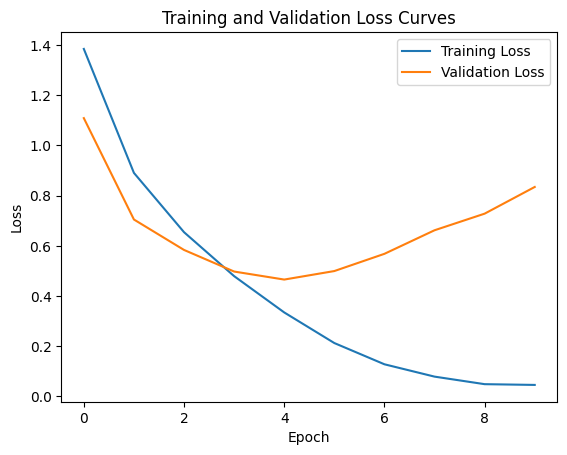

In [7]:
import matplotlib.pyplot as plt

plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


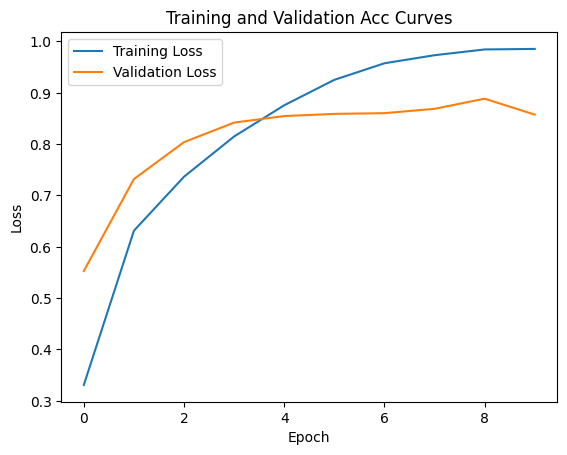

In [8]:
import matplotlib.pyplot as plt

plt.plot(trainAccs, label='Training Loss')
plt.plot(valAccs, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Acc Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/dlib_dog_emotion_dataset/test"

transform = transforms.Compose([
    transforms.Resize((456,456)),
    transforms.ToTensor(),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)

# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)


Test set: 709
4


In [10]:
# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
     
class DenseResidualBlock(nn.Module):
    """
    Dense Residual Block
    Processes input with skip connections and returns in the same number of channels

    inChannels (int): the number of input channels going into the block (and also being returned)
    internalSize (int): the number of channels within the internal layers of the block
    """
    def __init__(self, in_features, hidden_size=128, dropout_rate=0.3):
        super(DenseResidualBlock, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, in_features)
        self.bn2 = nn.BatchNorm1d(in_features)

    def forward(self, x):
        identity = x  # Save for residual

        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.fc2(out)))

        return identity + out 
# Load EfficientNet structure

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

# Freeze everything
for param in model.parameters():
    param.requires_grad = False


# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(2048, 128),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Dropout(p=0.3),
    DenseResidualBlock(in_features=256),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)

# Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load weights
model.load_state_dict(torch.load("../../models/clean/SEN.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8547
Classification Report:
              precision    recall  f1-score   support

       angry       0.93      0.90      0.92       157
       happy       0.87      0.94      0.90       236
     relaxed       0.83      0.81      0.82       205
         sad       0.75      0.68      0.71       111

    accuracy                           0.85       709
   macro avg       0.85      0.83      0.84       709
weighted avg       0.85      0.85      0.85       709

Confusion Matrix:
[[141   5   7   4]
 [  3 222   7   4]
 [  2  18 167  18]
 [  5  11  19  76]]


## Sorry I refuse to do SWIN with 19k